## Fashion MNIST Basic GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import matplotlib
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/fashion', one_hot = True, reshape= False)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


Printing the shapes

In [3]:
X_train = data.train.images
y_train = data.train.labels

X_test = data.test.images
y_test = data.test.labels

In [4]:
print (X_train.shape)
print (y_train.shape)

(55000, 28, 28, 1)
(55000, 10)


In [34]:
index2label = {0 : "T-shirt/top",
               1 : "Trouser",
               2 : "Pullover",
               3 : "Dress",
               4 : "Coat",
               5 : "Sandal",
               6 : "Shirt",
               7 : "Sneaker",
               8 : "Bag",
               9 : "Ankle boot",
              }

Helper Functions for displaying images

In [35]:
def display_digit(x, y, i):
    s = [i for i,x in enumerate(y_train[i]) if x == 1]
    label = index2label.get(s[0])
    image = x[i].reshape([28,28])
    plt.title('Example: %d  Label: %s' % (i, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

def display_mult_flat(start, stop, x):
    images = x[start].reshape([1,784])
    for i in range(start + 1, stop):
        images = np.concatenate((images, x[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray'))
    plt.show()

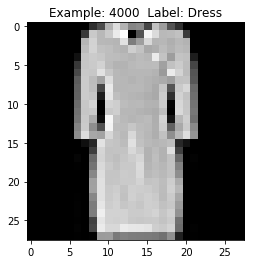

In [36]:
display_digit(X_train, y_train, 4000)

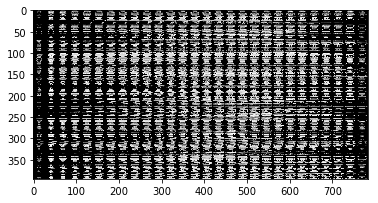

In [44]:
display_mult_flat(5,400,X_train)

In [6]:
def plot_images_separately(images):
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

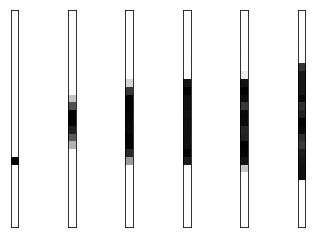

In [7]:
plot_images_separately(X_train[0])

In [8]:
def plot_images_together(images):
    fig = plt.figure()
    images = [image[:, :] for image in images]
    image = np.concatenate(images, axis=1)
    ax = fig.add_subplot(1, 3, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

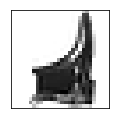

In [9]:
plot_images_together(X_train[5])

### Building the model

In [11]:
def input_placeholders(real, fake):
    X_real = tf.placeholder(tf.float32, shape=[None, real], name="X_real")
    X_fake = tf.placeholder(tf.float32, shape=[None, fake], name="X_fake")
    
    return X_real, X_fake

Generator

In [12]:
def generator(fake, channels, hidden_units, reuse):
    with tf.variable_scope('generator', reuse = reuse):
        model = tf.layers.dense(fake, hidden_units, activation = None)
        model = tf.maximum(0.01 * model, model)
        model = tf.layers.dense(model, channels, activation = None)
        model = tf.tanh(model)
        
        return model

Discriminator 

In [13]:
def discriminator(real, hidden_units, reuse):
    with tf.variable_scope('discriminator', reuse = reuse):
        model = tf.layers.dense(real, hidden_units, activation = None)
        model = tf.maximum(0.01 * model, model)
        model = tf.layers.dense(model, 1, activation = None)
        output = tf.sigmoid(model)
    
    return output, model

In [14]:
## Dimension for generator and discriminator
fake_dim = 128
real_dim = 784

## Units in hidden layers 
hidden_units_fake = 128
hidden_units_real = 128

## Output Dimension
channels = 128

In [16]:
tf.reset_default_graph()

##Placeholders for dimensions
X_real, X_fake = input_placeholders(real_dim, fake_dim)

## Generator
model_generator = generator(X_fake, channels = real_dim, hidden_units = hidden_units_fake, reuse = False)

## Discriminator_REAL
model_discriminator_real, logits_discriminator_real = discriminator(X_real, hidden_units = hidden_units_real, 
                                                                    reuse = False)
## Discriminator_FAKE
model_discriminator_fake, logits_discriminator_fake = discriminator(model_generator, hidden_units = hidden_units_real, 
                                                                    reuse = True)

Calculating Losses for Generator and Discriminator

In [17]:
loss_discriminator_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_discriminator_real) * (1 - 0.1)
                                                ,logits= logits_discriminator_real))

loss_discriminator_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_discriminator_real)
                                                ,logits = logits_discriminator_fake))

## Discriminator Loss 
loss_discriminator = loss_discriminator_real + loss_discriminator_fake

## Generator Loss
loss_generator = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_discriminator_fake), 
                                                logits = logits_discriminator_fake))

In [18]:
learning_rate = 0.003

variables = tf.trainable_variables()
generator_variables = [var for var in variables if var.name.startswith('generator')]
discriminator_variables = [var for var in variables if var.name.startswith('discriminator')]

discriminator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_discriminator, var_list = discriminator_variables)
generator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_generator, var_list = generator_variables)

In [19]:
batch_size = 128
epochs = 100
samples = []
losses = []

Training the network

In [22]:
%%time

saver = tf.train.Saver(var_list=generator_variables)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(data.train.num_examples//batch_size):
            batch = data.train.next_batch(batch_size)
            
            # passing images to discriminator
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # inputs for generator
            batch_fake = np.random.uniform(-1, 1, size=(batch_size, fake_dim))
            
            _ = sess.run(discriminator_optimizer, feed_dict={X_real: batch_images, X_fake: batch_fake})
            _ = sess.run(generator_optimizer, feed_dict={X_fake: batch_fake})
        
        train_loss_d = sess.run(loss_discriminator, {X_fake: batch_fake, X_real: batch_images})
        train_loss_g = loss_generator.eval({X_fake: batch_fake})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    

        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator
        sample_fake = np.random.uniform(-1, 1, size=(16, fake_dim))
        gen_samples = sess.run(
                       generator(X_fake, channels=real_dim, hidden_units = hidden_units_fake, reuse=True),
                       feed_dict={X_fake: sample_fake})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

Epoch 1/100... Discriminator Loss: 0.4273... Generator Loss: 3.1165
Epoch 2/100... Discriminator Loss: 0.5712... Generator Loss: 2.9901
Epoch 3/100... Discriminator Loss: 0.5337... Generator Loss: 4.2315
Epoch 4/100... Discriminator Loss: 1.0284... Generator Loss: 2.3837
Epoch 5/100... Discriminator Loss: 0.6533... Generator Loss: 3.7145
Epoch 6/100... Discriminator Loss: 0.5764... Generator Loss: 3.5954
Epoch 7/100... Discriminator Loss: 0.6081... Generator Loss: 3.7393
Epoch 8/100... Discriminator Loss: 0.9160... Generator Loss: 1.7152
Epoch 9/100... Discriminator Loss: 0.7482... Generator Loss: 2.6840
Epoch 10/100... Discriminator Loss: 0.8387... Generator Loss: 2.4342
Epoch 11/100... Discriminator Loss: 0.6436... Generator Loss: 2.5116
Epoch 12/100... Discriminator Loss: 0.8067... Generator Loss: 2.6418
Epoch 13/100... Discriminator Loss: 0.6208... Generator Loss: 3.2855
Epoch 14/100... Discriminator Loss: 0.6419... Generator Loss: 3.5785
Epoch 15/100... Discriminator Loss: 0.9416.

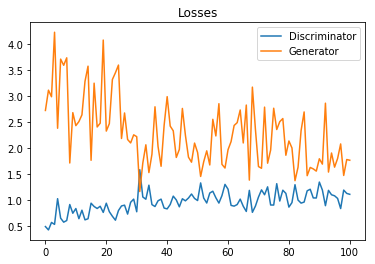

In [24]:
## Plotting the Losses
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Losses")
plt.legend()

In [25]:
## Saving the samples
with open('./samples/train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

In [26]:
## Loading the samples
with open('./samples/train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

(<matplotlib.figure.Figure at 0x11e9d2048>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121f6a358>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x11ef100f0>]], dtype=object))

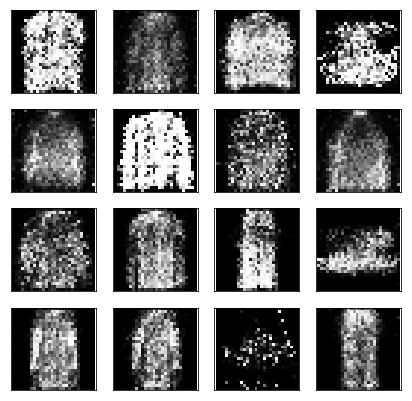

In [27]:
view_samples(-1, samples)

Sampling images as network was training every 10 epochs

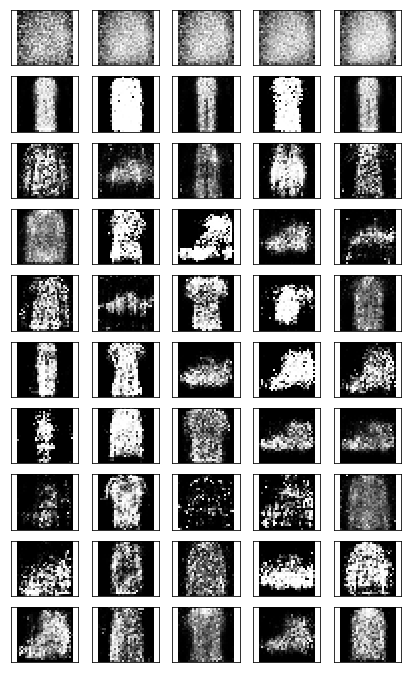

In [30]:
rows, cols = 10, 5
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

Sampling from generator

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


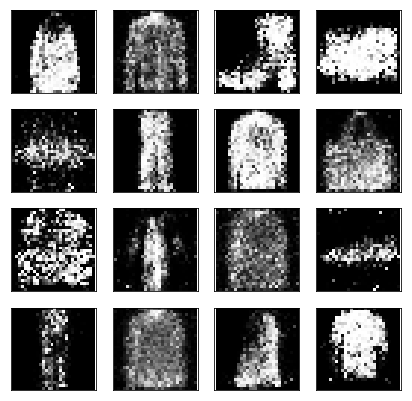

In [31]:
saver = tf.train.Saver(var_list=generator_variables)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, fake_dim))
    gen_samples = sess.run(
                   generator(X_fake, real_dim, hidden_units_real,reuse=True),
                   feed_dict={X_fake: sample_z})
_ = view_samples(0, [gen_samples])